# **¿Qué es el reconocimiento óptico de caracteres (OCR)?**


El **reconocimiento óptico de caracteres** (**OCR**) es el proceso por el cual se convierte una imagen de texto en un formato de texto que pueden leer las máquinas. Por ejemplo, si escanea el formulario o un recibo, su computadora guarda el escaneo como un archivo de imagen. No se puede utilizar un editor de texto para editar, buscar o contar las palabras del archivo de imagen. Sin embargo, se puede utilizar el OCR para convertir la imagen en un documento de texto con su contenido como datos de texto.


In [ ]:
pip install opencv-python matplotlib numpy scikit-image easyocr transformers opencv-python-headless openai requests

# **Histograma y Binarizacion**

La mayoría de los algoritmos de reconocimiento óptico de caracteres (OCR) trabajan con imágenes en blanco y negro (también llamadas binarias). Por eso, es importante convertir primero una imagen a blanco y negro, ya sea que venga en color o en escala de grises.

Una forma común de hacerlo es usando un umbral: si un píxel es menos intenso que ese valor, se convierte en negro; si es más intenso, se vuelve blanco. Para elegir ese umbral, podemos usar el histograma de la imagen, que nos muestra cuántos píxeles hay en cada nivel de gris.

Esto ayuda a conservar lo más importante del texto o las formas, eliminando detalles innecesarios.










In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert
import easyocr
from transformers import pipeline
from ipywidgets import interact, IntSlider
from openai import OpenAI
from google.colab import userdata
import requests

def procesar_imagen(imagen, umbral):
  # Calcular histograma
  histograma = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
  # Aplicar umbral
  _, imagen_bn = cv2.threshold(gray_img, umbral, 255, cv2.THRESH_BINARY)
  return histograma, imagen_bn;

def leer_imagen(url):
  # Descargar la imagen
  response = requests.get(url)
  image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
  # Decodificar la imagen con OpenCV
  img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
  return img

# URLs de las imagenes
img_grises = "https://github.com/tanialoaiza/taller03_dportenis/blob/main/03.%20Imagen%20-_%20Estructura/Imagenes/Grises.png?raw=true"
img_mario = "https://github.com/tanialoaiza/taller03_dportenis/blob/main/03.%20Imagen%20-_%20Estructura/Imagenes/Mario.jpg?raw=true"
img_dpvale = "https://github.com/tanialoaiza/taller03_dportenis/blob/main/03.%20Imagen%20-_%20Estructura/Imagenes/dpvale.png?raw=true"
img_documento = "https://github.com/tanialoaiza/taller03_dportenis/blob/main/03.%20Imagen%20-_%20Estructura/Imagenes/Documento.png?raw=true"


img = leer_imagen(img_grises)
# Convertir la imagen de BGR a RGB para mostrar correctamente
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#  Convertir la imagen a escala de grises
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

umbral = 128

histograma, binaria = procesar_imagen(gray_img, umbral)

# Mostrar resultados
plt.figure(figsize=(15, 5))

# Imagen original en escala de grises
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')

# Histograma
plt.subplot(1, 3, 2)
plt.plot(histograma, color='black')
plt.title('Histograma')
plt.xlabel('Intensidad')
plt.ylabel('Frecuencia')
plt.grid(True)

# Imagen en blanco y negro
plt.subplot(1, 3, 3)
plt.imshow(binaria, cmap='gray')
plt.title(f'Binaria (umbral = {umbral})')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Función para aplicar el umbral y mostrar la imagen
def aplicar_umbral(umbral):
    # Convertir a RGB para mejor visuazizacion
    img_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    # Convertir a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)


    _, imagen_bn = cv2.threshold(gris, umbral, 255, cv2.THRESH_BINARY)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gris, cmap='gray')
    plt.title('Escala de grises')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(imagen_bn, cmap='gray')
    plt.title(f'Blanco y negro ')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Cargar imagen en escala de grises
imagen = leer_imagen(img_mario)
umbral = 128

# Slider interactivo entre 0 y 255
interact(aplicar_umbral, umbral=IntSlider(value=150, min=0, max=255, step=1))

In [ ]:
# Cargar imagen
imagen = leer_imagen(img_dpvale)

interact(aplicar_umbral, umbral=IntSlider(value=128, min=0, max=255, step=1))

# **Fragmentación o segmentación de la imagen**

Es el proceso de separar los distintos elementos de una imagen, como letras o palabras. Es un paso clave para que un sistema pueda reconocer los caracteres. Normalmente se usan métodos que detectan diferencias de color o intensidad (como el histograma o proyecciones), dividiendo la imagen en regiones más fáciles de analizar. No hay una técnica única que funcione para todos los casos, pero los métodos por proyecciones son de los más comunes.

In [ ]:
# Configurar el umbral
def detectar_lineas(binaria):
  # Binarización


  # Proyección horizontal para detectar líneas
  proyeccion_h = np.sum(binaria, axis=1)

  inicio_linea, lineas = None, []
  for i, val in enumerate(proyeccion_h):
      if val > 0 and inicio_linea is None:
          inicio_linea = i
      elif val == 0 and inicio_linea is not None:
          fin_linea = i
          lineas.append((inicio_linea, fin_linea))
          inicio_linea = None

  # Detección vertical (por línea) para segmentar caracteres
  imagen_color = cv2.cvtColor(binaria, cv2.COLOR_GRAY2BGR)

  for (yi, yf) in lineas:
      linea = binaria[yi:yf, :]  # recorta la línea
      proyeccion_v = np.sum(linea, axis=0)

      inicio_char, caracteres = None, []

      for x, val in enumerate(proyeccion_v):
          if val > 0 and inicio_char is None:
              inicio_char = x
          elif val == 0 and inicio_char is not None:
              fin_char = x
              caracteres.append((inicio_char, fin_char))
              inicio_char = None

      # Dibujar caracteres en la imagen original
      for (xi, xf) in caracteres:
          cv2.rectangle(imagen_color, (xi, yi), (xf, yf), (0, 0, 255), 1)


  # Mostrar resultado
  plt.figure(figsize=(12, 8))
  plt.imshow(imagen_color)
  plt.title('Segmentación por líneas y caracteres')
  plt.axis('off')




In [ ]:
imagen_color = leer_imagen(img_dpvale)
imagen_gray = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2GRAY)
umbral =41
_, imagen_bin_inv = cv2.threshold(imagen_gray, umbral, 255, cv2.THRESH_BINARY_INV)
detectar_lineas(imagen_bin_inv)

# **Adelgazamiento de los componentes**

Es un proceso que afina las formas de los caracteres, quitando los bordes poco a poco hasta dejar solo una línea central (como un esqueleto). Se hace cuidadosamente para que la forma original no se deforme. Esto ayuda a que sea más fácil reconocer y comparar letras.

skeletonize: funciona mediante pasadas sucesivas de la imagen. En cada pasada, se identifican y eliminan los píxeles del borde siempre que no interrumpan la conectividad del objeto correspondiente.

In [ ]:
# Convertir a booleano para skeletonize
imagen_bool = imagen_bin_inv > 0

# Aplicar adelgazamiento
esqueleto = skeletonize(imagen_bool)

# Convertir booleanos a uint8 para mostrar
imagen_bin_inv_uint8 = imagen_bin_inv
esqueleto_uint8 = esqueleto.astype(np.uint8) * 255

# Mostrar resultados
plt.figure()


plt.subplot(1,2,1)
plt.imshow(imagen_bin_inv_uint8, cmap='gray')
plt.title('Binaria invertida')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(esqueleto_uint8, cmap='gray')
plt.title('Esqueleto (adelgazado)')
plt.axis('off')

plt.show()

# **Reconocimiento de texto**


**Coincidencia de patrones**


La coincidencia de patrones aísla una imagen de carácter, llamada glifo, y la compara con un glifo almacenado de manera similar. El reconocimiento de patrones solo funciona si el glifo almacenado tiene una fuente y una escala similares a las del glifo de entrada. Este método funciona bien con imágenes escaneadas de documentos que se han escrito en una fuente conocida.




**Extracción de características**


La extracción de características divide o descompone los glifos en características como líneas, circuitos cerrados, dirección de línea e intersecciones de línea. Luego, utiliza estas características para encontrar la mejor coincidencia o el vecino más cercano entre los glifos almacenados.

En el siguiente ejemplo usamos la libreria EasyOCR para hacer la deteccion de caracteres de forma sencilla y rapida pasando la imagen adelgazada


In [ ]:
# Crear lector EasyOCR
lector = easyocr.Reader(['en', 'es'], gpu=False)

# Leer texto
resultados = lector.readtext(esqueleto_uint8)

# Convertir esqueleto a imagen BGR para dibujar sobre él
esqueleto_bgr = cv2.cvtColor(esqueleto_uint8, cv2.COLOR_GRAY2BGR)

# Dibujar resultados sobre imagen
for (bbox, texto, prob) in resultados:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

    # Dibujar rectángulo
    cv2.rectangle(esqueleto_bgr, top_left, bottom_right, (0, 255, 0), 2)
    # Dibujar texto
    cv2.putText(esqueleto_bgr, f'{texto}', (top_left[0], top_left[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(esqueleto_bgr, cv2.COLOR_BGR2RGB))
plt.title("Detección EasyOCR sobre el esqueleto")
plt.axis('off')
plt.show()

# Mostrar texto detectado
for _, texto, prob in resultados:
    print(f'Texto: "{texto}", Confianza: {prob:.2f}')

# **Ejemplo con recibo digital**

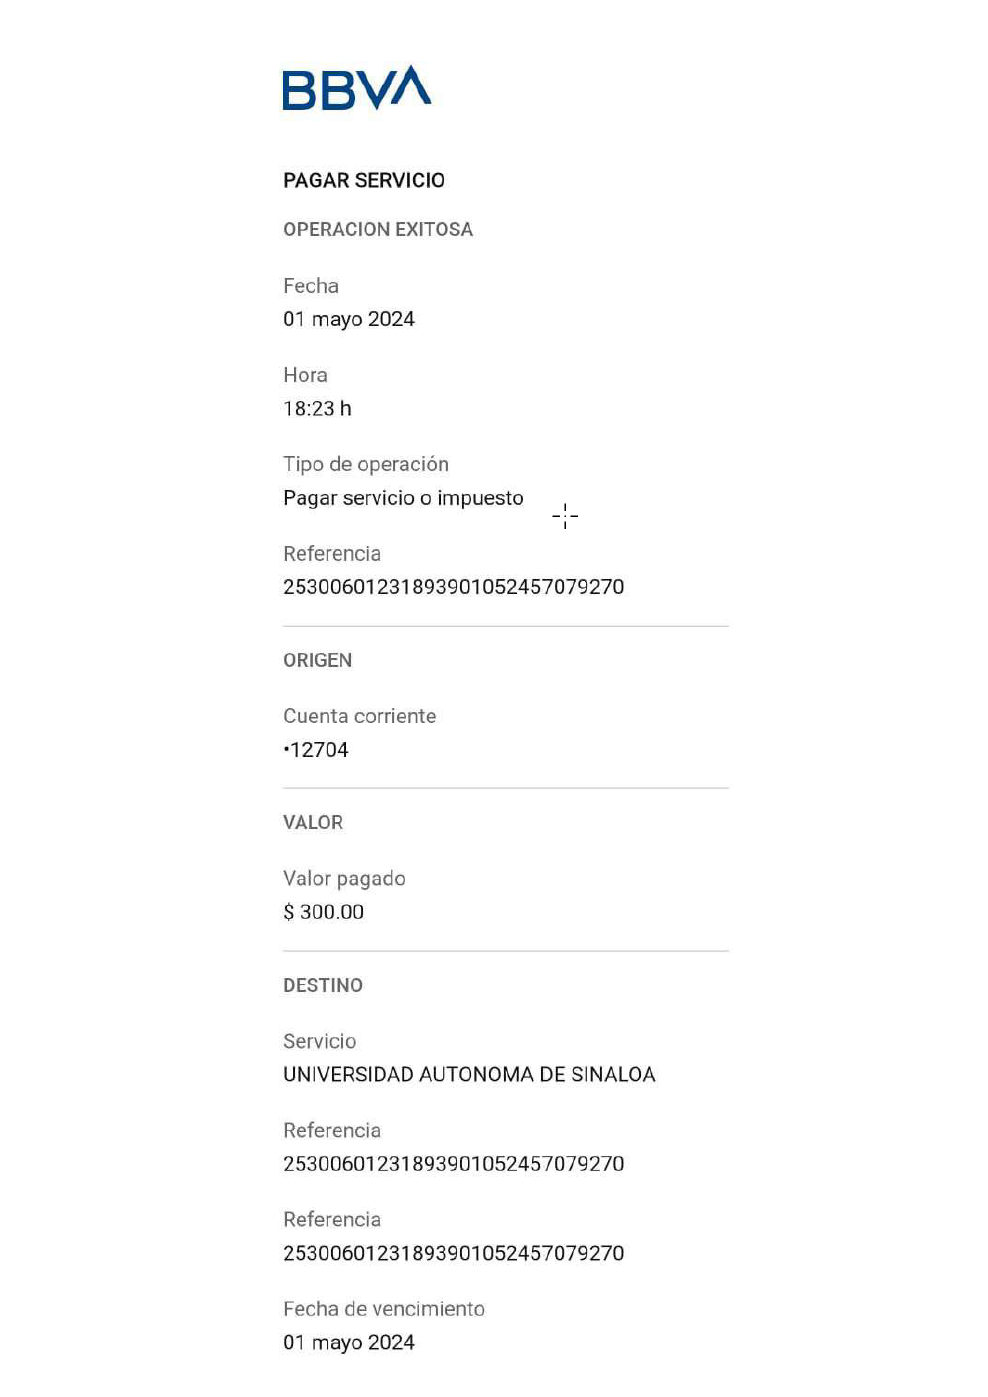

In [ ]:
img = cv2.cvtColor(leer_imagen(img_documento), cv2.COLOR_BGR2GRAY)
umbral = 180
_, imagen_bin_inv = cv2.threshold(img, umbral, 255, cv2.THRESH_BINARY_INV)

# Crear lector EasyOCR (idioma español e inglés)
lector = easyocr.Reader(['en', 'es'], gpu=False)  # gpu=True si tienes CUDA

# Convertir a booleano para skeletonize
imagen_bool = imagen_bin_inv > 0

imagen_bin_inv_uint8 = imagen_bin_inv
# Aplicar adelgazamiento
esqueleto = skeletonize(imagen_bool)
esqueleto_uint8 = esqueleto.astype(np.uint8) * 255



# Leer texto
resultados = lector.readtext(imagen_bin_inv)

# Convertir esqueleto a imagen BGR para dibujar sobre él
esqueleto_bgr = cv2.cvtColor(esqueleto_uint8, cv2.COLOR_GRAY2BGR)

# Dibujar resultados sobre imagen
for (bbox, texto, prob) in resultados:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = (int(top_left[0]), int(top_left[1]))
    bottom_right = (int(bottom_right[0]), int(bottom_right[1]))

    # Dibujar rectángulo
    cv2.rectangle(esqueleto_bgr, top_left, bottom_right, (0, 255, 0), 2)


plt.imshow(cv2.cvtColor(esqueleto_bgr, cv2.COLOR_BGR2RGB))
plt.title("Detección EasyOCR sobre el esqueleto")
plt.axis('off')
plt.show()

# Mostrar texto detectado
for _, texto, prob in resultados:
    print(f'Texto: "{texto}", Confianza: {prob:.2f}')

In [ ]:
import json

# Inicializamos variables
info = {
    "fecha": None,
    "hora": None,
    "tipo_operacion": None,
    "valor_pagada": None,
    "fecha_vencimiento": None
}

# Bandera para detectar campos previos al valor que queremos guardar
campo_actual = None

for _, texto, _ in resultados:
    texto_limpio = texto.strip().lower()

    if "fecha de vencimiento" in texto_limpio:
        campo_actual = "fecha_vencimiento"
    elif texto_limpio == "fecha":
        campo_actual = "fecha"
    elif texto_limpio == "hora":
        campo_actual = "hora"
    elif "tipo de operación" in texto_limpio or "tipo de operacion" in texto_limpio:
        campo_actual = "tipo_operacion"
    elif "valor pagada" in texto_limpio:
        campo_actual = "valor_pagada"
    elif campo_actual:
        # Guardamos el valor en el campo correspondiente
        if info[campo_actual] is None:
            info[campo_actual] = texto.strip()
            campo_actual = None  # Reset para no guardar valores innecesarios

# Mostrar JSON
json_str = json.dumps(info, ensure_ascii=False, indent=2)
print(json_str)

**Ejercicio:**

Extrae los campos de fecha, hora, tipo de operacion, valor pagado y fecha de vencimiento en formato json usando gemini.

In [ ]:
client = OpenAI(
    api_key=userdata.get('GOOGLE_API_KEY'),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

prompt = f"""

{resultados}
"""

message = [
        {
            "role": "user",
            "content": (
                prompt
            )
        }
    ]

response = client.chat.completions.create(
  model="models/gemini-2.0-flash",
  messages=message)

print(response.choices[0].message.content.strip())

# **Otras opciones: Jina.ai Reader**

**Extraccion desde pdf**

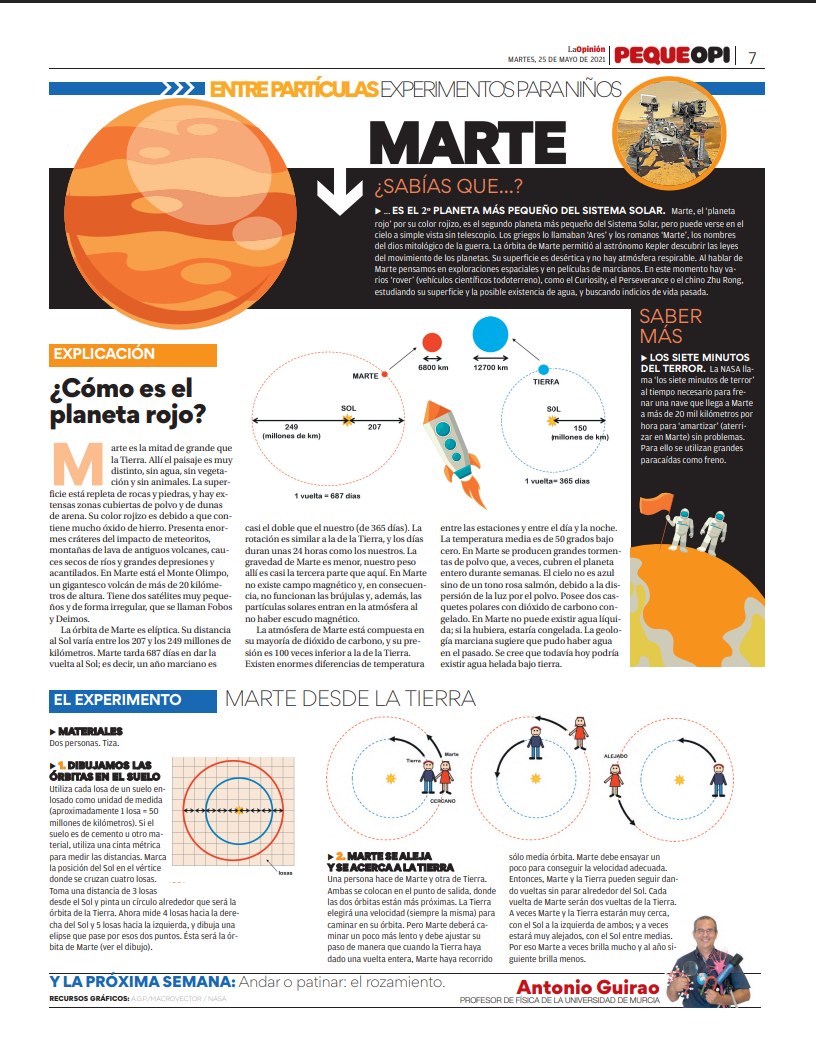

In [ ]:
import requests
import textwrap
client = OpenAI(
    api_key=userdata.get('GOOGLE_API_KEY'),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

reader_api_url = f"https://r.jina.ai/https://www.um.es/phi/aguirao/EntreParticulas/PDF/2021%20mayo25.pdf"

response = requests.get(reader_api_url)
if response.status_code == 200:
    text_md = response.text

    for line in response.iter_lines():
      if line:
        print(line.decode('utf-8'))

    prompt = f"""Dame los titulos y subtitulos del texto
    {text_md}
    """

    message = [
            {
                "role": "user",
                "content": (
                    prompt
                )
            }
        ]

    response = client.chat.completions.create(
      model="models/gemini-2.0-flash",
      messages=message)

    respuesta = response.choices[0].message.content
    #print("OCR:")
    #print(textwrap.fill(text_md, width=150))
    print(" ")
    print("Transcipcion reader + GPT:")
    print(textwrap.fill(respuesta, width=150))
else:
    print("Error al acceder a Jina Reader API")